In [1]:
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=$(awk '/download/ {print $NF}' ./cookie)&id=11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe" -o data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2423  100  2423    0     0   5844      0 --:--:-- --:--:-- --:--:--     0


In [2]:
!pip install gdown
!gdown https://drive.google.com/uc?id=11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe -O data.zip

Downloading...
From (original): https://drive.google.com/uc?id=11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe
From (redirected): https://drive.google.com/uc?id=11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe&confirm=t&uuid=f299d09a-ab3d-4544-83f8-dd0ee76db5d8
To: /content/data.zip
100% 154M/154M [00:01<00:00, 83.9MB/s]


In [3]:
!unzip data.zip -d /content/people_photos/


Archive:  data.zip
   creating: /content/people_photos/dataset/
   creating: /content/people_photos/dataset/masks/
  inflating: /content/people_photos/dataset/masks/1803262049-00000501.png  
  inflating: /content/people_photos/dataset/masks/1803280840-00000089.png  
  inflating: /content/people_photos/dataset/masks/1803242348-00000392.png  
  inflating: /content/people_photos/dataset/masks/1803251131-00000060.png  
  inflating: /content/people_photos/dataset/masks/1803240928-00000328.png  
  inflating: /content/people_photos/dataset/masks/1803260459-00000293.png  
  inflating: /content/people_photos/dataset/masks/1803271238-00000380.png  
  inflating: /content/people_photos/dataset/masks/1803280628-00000458.png  
  inflating: /content/people_photos/dataset/masks/1803280908-00000324.png  
  inflating: /content/people_photos/dataset/masks/1803260434-00000062.png  
  inflating: /content/people_photos/dataset/masks/1803241125-00000172.png  
  inflating: /content/people_photos/dataset/masks

In [4]:
import cv2

img = cv2.imread("/content/people_photos/dataset/images/1803260054-00000353.jpg", cv2.IMREAD_UNCHANGED)
mask = cv2.imread("/content/people_photos/dataset/masks/1803260054-00000353.png", cv2.IMREAD_UNCHANGED)[..., -1]

In [5]:
import matplotlib.pyplot as plt

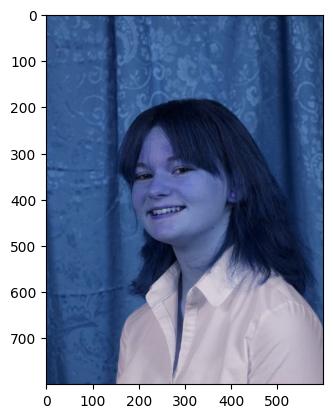

In [ ]:
plt.imshow(img)

In [6]:
from glob import glob
# imgs_list - это список путей к изображениям
imgs_list = glob("/content/people_photos/dataset/images/**/*.jpg", recursive=True)

In [7]:
from torch.utils.data import Dataset
import numpy as np
import torch
import cv2
from torchvision import transforms

class SelfieDataset(Dataset):
    def __init__(self, imgs_list, transform=None, mask_transform=None):
        self.imgs = imgs_list
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Построение пути к маске
        mask_path = img_path.replace("/images/", "/masks/").replace(".jpg", ".png")
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        # Добавление паддинга
        top = int((800 - 600) / 2)
        bottom = 800 - 600 - top
        img_padded = cv2.copyMakeBorder(img, top, bottom, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        mask_padded = cv2.copyMakeBorder(mask, top, bottom, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        # Преобразование PyTorch (включая изменение размера)
        if self.transform:
            img_padded = self.transform(img_padded)
        else:
            # Преобразование по умолчанию, если transform не задан
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
            ])
            img_padded = transform(img_padded)

        if self.mask_transform:
            mask_padded = self.mask_transform(mask_padded)
        else:
            # Преобразование по умолчанию, если mask_transform не задан
            mask_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
                transforms.ToTensor(),
            ])
            mask_padded = mask_transform(mask_padded)

        # Бинаризация маски
        mask_padded = (mask_padded > 0.5).float()

        return {"image": img_padded, "mask": mask_padded}

## train/test split

In [8]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs = train_test_split(imgs_list, test_size=0.2, random_state=42)

In [9]:
train_dataset = SelfieDataset(train_imgs)
test_dataset = SelfieDataset(test_imgs)

In [10]:
btch_sz = 32

In [11]:
mini_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=btch_sz, shuffle=True, num_workers=8)
loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=btch_sz, shuffle=True, num_workers=8)

## U-Net

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)




In [23]:
# Фиксация сидов
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

In [24]:
# Метрика Jaccard Index (IoU)

def jaccard_index(pred, target):
    # Преобразование тензоров к булевому типу для выполнения логических операций
    pred = pred.bool()
    target = target.bool()

    intersection = (pred & target).sum((1, 2))  # Пересечение
    union = (pred | target).sum((1, 2))  # Объединение

    iou = (intersection + 1e-6) / (union + 1e-6)  # Вычисление IoU с добавлением малого числа для избежания деления на ноль
    return iou.mean()  # Возвращение среднего значения IoU по батчу

## Обучение модели на одном батче

In [ ]:
# Получение одного батча из DataLoader
fixed_batch = next(iter(mini_train_loader))
images, masks = fixed_batch['image'], fixed_batch['mask']

In [ ]:
import torch.optim as optim

# Определение модели, функции потерь и оптимизатора
model = UNET(3, 16, 1)

# model = UNet(in_channels=3, out_channels=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# model = model.cuda()

# Получение одного батча
num_epochs = 100  # Вы можете настроить это число в зависимости от необходимости

for epoch in range(num_epochs):
    optimizer.zero_grad()  # Обнуление градиентов
    outputs = model(images)  # Предсказание модели
    loss = criterion(outputs, masks)  # Расчёт потерь
    loss.backward()  # Обратное распространение
    optimizer.step()  # Шаг оптимизации

    if epoch % 10 == 0:  # Печать информации каждые 10 эпох
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

Epoch 0/100, Loss: 0.7097612023353577
Epoch 10/100, Loss: 0.41636601090431213
Epoch 20/100, Loss: 0.3433760106563568
Epoch 30/100, Loss: 0.30570822954177856
Epoch 40/100, Loss: 0.2786071300506592
Epoch 50/100, Loss: 0.252712607383728
Epoch 60/100, Loss: 0.22969555854797363
Epoch 70/100, Loss: 0.21043473482131958
Epoch 80/100, Loss: 0.19276626408100128
Epoch 90/100, Loss: 0.17637969553470612


## Оценка метрики на батче и на тестовом наборе

In [ ]:

model.eval()  # Переключение модели в режим оценки
with torch.no_grad():  # Отключение вычисления градиентов
    outputs = model(images)
    preds = torch.sigmoid(outputs) > 0.5  # Преобразование выходов модели в бинарные маски
    iou_score = jaccard_index(preds, masks.bool())  # Вычисление IoU
    print(f'IoU на обучающем батче: {iou_score.item()}')

IoU на обучающем батче: 0.9831788539886475


In [ ]:
with torch.no_grad():
    # Оценка метрики на всем тестовом наборе
    iou_scores = []
    for batch in loader_test:
        images = batch['image']
        masks = batch['mask']
        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5
        iou_scores.append(jaccard_index(preds, masks.bool()))

    mean_iou = torch.mean(torch.tensor(iou_scores))
    print(f"Средний IoU на тесте: {mean_iou.item()}")

Средний IoU на тесте: 0.48413655161857605


### Вывод: успешное переобучение на одном батче
 Почти идеальный IoU на этом наборе данных (0.9831788539886475) и среднее значение IoU (0.48413655161857605) на тестовом наборе данных, что существенно ниже, чем на обучающем батче. Но подобное значение всё же указывает на то, что модель dвсё же способна обобщать изученные признаки на новых данных.

In [15]:
# Предположим, train_imgs содержит пути к обучающим изображениям
train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.2, random_state=42)

In [16]:
from torch.utils.data import DataLoader

train_dataset = SelfieDataset(train_imgs)
val_dataset = SelfieDataset(val_imgs)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализация модели, функции потерь и оптимизатора
model = UNET(3, 16, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, train_ious, val_ious = [], [], [], []

num_epochs = 25

# Early stop
best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 5  # Количество эпох без улучшений после которых обучение будет прервано
early_stop = False

for epoch in range(num_epochs):
    model.train()
    train_loss, train_iou = 0, 0
    for batch in train_loader:
        images, masks = batch['image'].to(device), batch['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)

    train_losses.append(train_loss / len(train_loader))
    train_ious.append(train_iou / len(train_loader))

    # Валидация
    model.eval()
    val_loss, val_iou = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            images, masks = batch['image'].to(device), batch['mask'].to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_iou += jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)

    val_losses.append(val_loss / len(val_loader))
    val_ious.append(val_iou / len(val_loader))


    # Проверка на необходимость ранней остановки
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f'\nEarly stopping after {epoch+1} epochs!')
            early_stop = True
            break

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train IoU: {train_ious[-1]}, Val IoU: {val_ious[-1]}')


Epoch 1, Train Loss: 0.5674429818987846, Val Loss: 0.533438777923584, Train IoU: 0.5793637633323669, Val IoU: 0.31367334723472595
Epoch 2, Train Loss: 0.38621133789420126, Val Loss: 0.3627825528383255, Train IoU: 0.7443777918815613, Val IoU: 0.7510437965393066
Epoch 3, Train Loss: 0.295204222202301, Val Loss: 0.32077949345111845, Train IoU: 0.7858672142028809, Val IoU: 0.7213048338890076
Epoch 4, Train Loss: 0.22257605269551278, Val Loss: 0.218474879860878, Train IoU: 0.81976717710495, Val IoU: 0.8003277778625488
Epoch 5, Train Loss: 0.17482220828533174, Val Loss: 0.18611981272697448, Train IoU: 0.8392273187637329, Val IoU: 0.8276691436767578
Epoch 6, Train Loss: 0.14019068218767644, Val Loss: 0.1454639106988907, Train IoU: 0.867047905921936, Val IoU: 0.8627908825874329
Epoch 7, Train Loss: 0.11810825411230326, Val Loss: 0.1328995332121849, Train IoU: 0.8829140067100525, Val IoU: 0.8664488196372986
Epoch 8, Train Loss: 0.10207183174788952, Val Loss: 0.12215095609426499, Train IoU: 0.89

Наибольшее значение метрики IoU (0.9405174255371094) достигается на 21 эпохе.

## Визуализация train/val кривых для loss и IoU

In [21]:
train_ious = [ious.item() for ious in train_ious]
val_ious = [ious.item() for ious in val_ious]

In [22]:

print(train_ious)
print(val_ious)

print(train_losses)
print(val_losses)

[0.5793637633323669, 0.7443777918815613, 0.7858672142028809, 0.81976717710495, 0.8392273187637329, 0.867047905921936, 0.8829140067100525, 0.892528235912323, 0.910615086555481, 0.9176902174949646, 0.9285498857498169, 0.9325292706489563, 0.940832793712616, 0.9452912211418152, 0.9450761675834656, 0.9489240050315857, 0.9550447463989258, 0.9607301950454712, 0.9647353291511536, 0.9693893790245056, 0.9707271456718445, 0.9715306162834167, 0.9699236750602722, 0.9639521837234497, 0.9595006108283997]
[0.31367334723472595, 0.7510437965393066, 0.7213048338890076, 0.8003277778625488, 0.8276691436767578, 0.8627908825874329, 0.8664488196372986, 0.8758422136306763, 0.8960223197937012, 0.8976542353630066, 0.891866147518158, 0.9188179969787598, 0.9192530512809753, 0.907867431640625, 0.9120937585830688, 0.9165155291557312, 0.9239255785942078, 0.9325228929519653, 0.9332114458084106, 0.9365215301513672, 0.9405174255371094, 0.9256744384765625, 0.9311079382896423, 0.9203559756278992, 0.9240359663963318]
[0.56

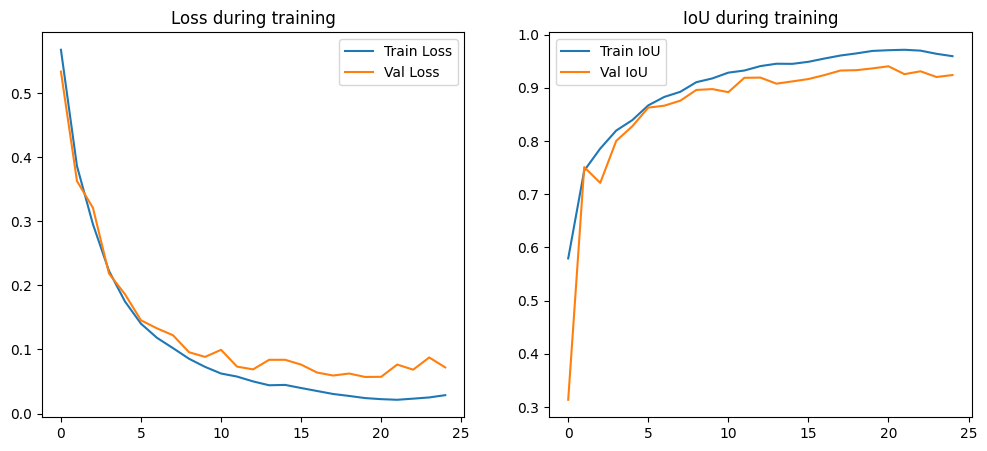

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss during training')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.title('IoU during training')
plt.legend()

plt.show()

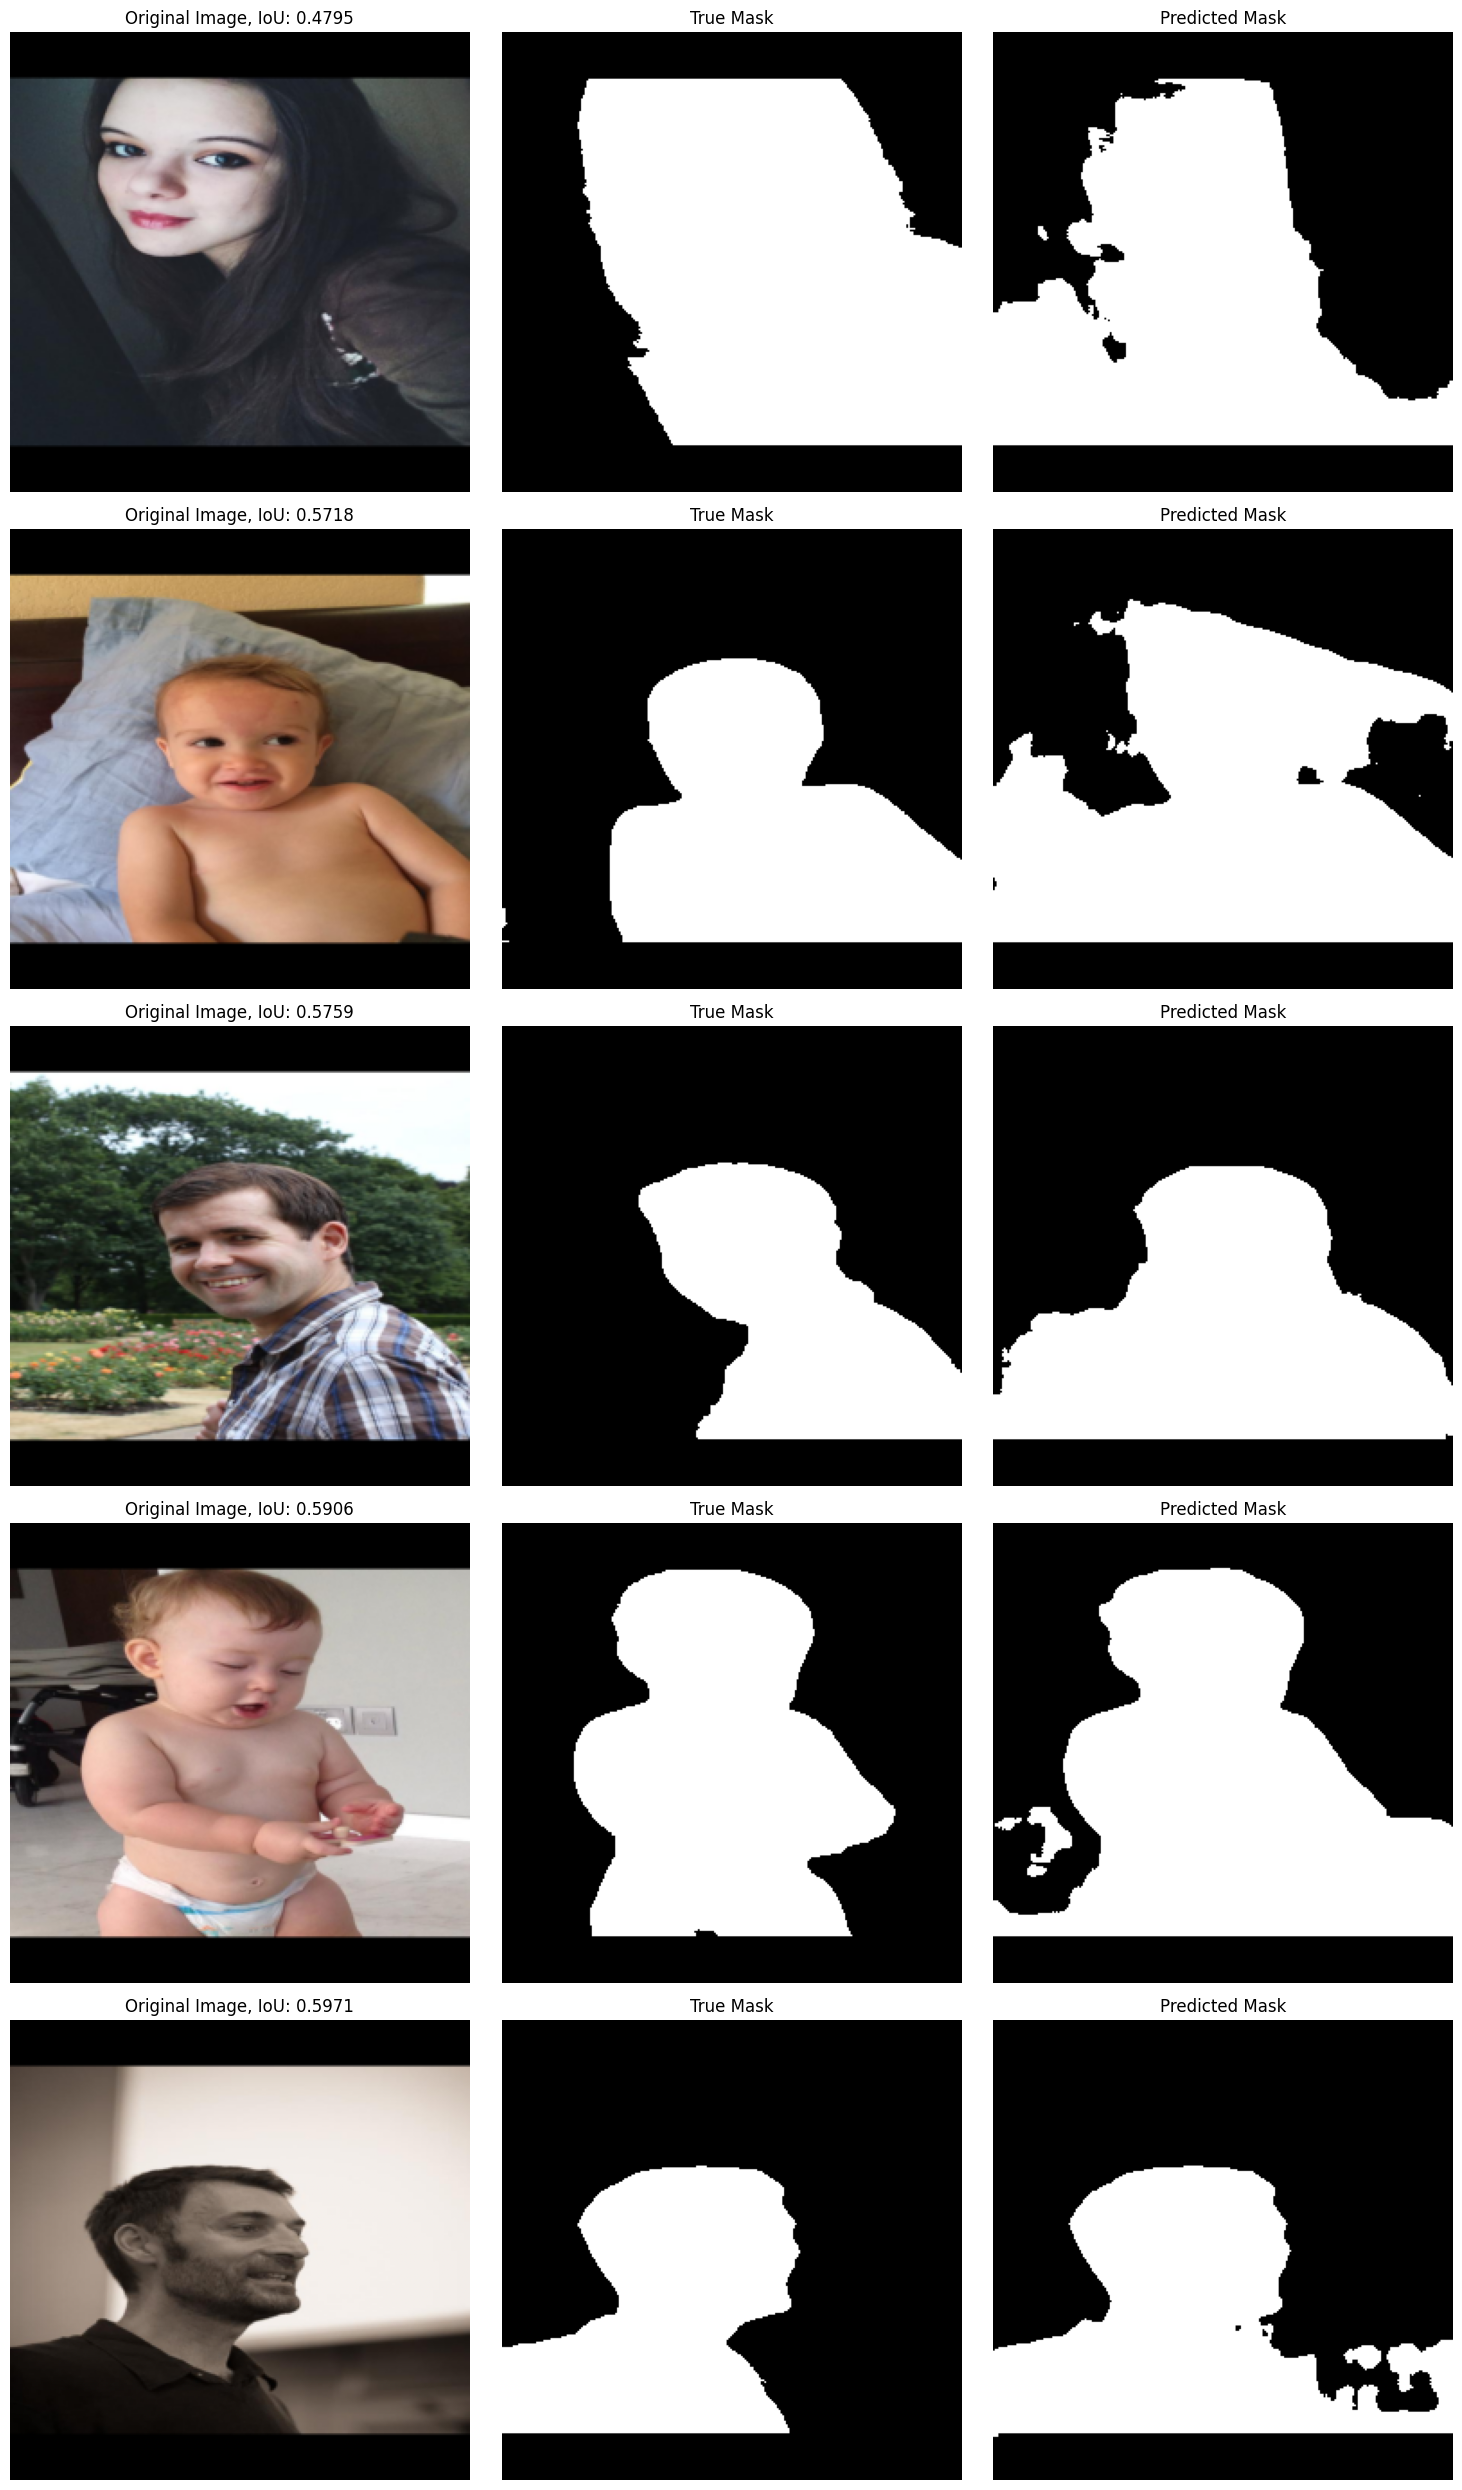

In [24]:
model.eval()
ious = []
images_to_show = []
with torch.no_grad():
    for batch in val_loader:
        images, masks = batch['image'].to(device), batch['mask'].to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        batch_ious = [jaccard_index(pred.unsqueeze(0), mask.unsqueeze(0)).item() for pred, mask in zip(preds, masks)]
        ious.extend(batch_ious)
        images_to_show.extend(list(zip(images.cpu(), masks.cpu(), preds.cpu())))

top_n = 5
sorted_indices = np.argsort(ious)[:top_n]
worst_predictions = [images_to_show[i] for i in sorted_indices]

# Визуализация топ-5 самых плохих предсказаний
fig, axes = plt.subplots(top_n, 3, figsize=(15, top_n * 5))
for i, (image, mask, pred) in enumerate(worst_predictions):
    # Преобразование тензоров обратно в изображения для отображения
    img_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.squeeze().numpy()
    pred_np = pred.squeeze().numpy()  # Использование сохраненного предсказания

    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f'Original Image, IoU: {ious[sorted_indices[i]]:.4f}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask_np, cmap='gray')
    axes[i, 1].set_title('True Mask')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(pred_np, cmap='gray')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

In [25]:
# загрузим лучшую модель
model.load_state_dict(torch.load('best_model.pth'))

# Перевод модели в режим оценки
model.eval()

test_loss, test_iou = 0, 0
test_ious = []  # Список для сохранения IoU каждого тестового батча

# Отключение вычисления градиентов для ускорения и экономии памяти
with torch.no_grad():
    for batch in loader_test:
        images, masks = batch['image'].to(device), batch['mask'].to(device)

        # Получение предсказаний модели
        outputs = model(images)

        # Расчет потерь
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        # Расчет IoU и сохранение результатов
        iou = jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)
        test_ious.append(iou.item())

# Расчет средних значений потерь и IoU по всему тестовому набору
average_test_loss = test_loss / len(loader_test)
average_test_iou = sum(test_ious) / len(test_ious)

print(f'Test Loss: {average_test_loss}, Test IoU: {average_test_iou}')


Test Loss: 0.05667875764461664, Test IoU: 0.9329923941538885


Результат на тестовых данных чуть хуже, чем на валидационной выборке.
Вывод: модель хорошо адаптируется к новым данным и минимально подвержена переобучению. Производительность модели на тестовом наборе данных, с потерями около 0.056 и IoU около 0.933, свидетельствует о высокой точности сегментации.

In [ ]:
import os

# Путь к папке, где вы хотите сохранить файлы
folder_path = '/content/drive/My Drive/YourFolderName'

# Создание папки, если она не существует
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [ ]:
import pickle

# Сохранение списков путей к изображениям
with open('/content/drive/My Drive/train_imgs.pkl', 'wb') as f:
    pickle.dump(train_imgs, f)

with open('/content/drive/My Drive/val_imgs.pkl', 'wb') as f:
    pickle.dump(val_imgs, f)

with open('/content/drive/My Drive/test_imgs.pkl', 'wb') as f:
    pickle.dump(test_imgs, f)


In [ ]:
# Сохранение истории обучения
training_history = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_ious": train_ious,
    "val_ious": val_ious
}

with open('/content/drive/My Drive/training_history.pkl', 'wb') as f:
    pickle.dump(training_history, f)


In [ ]:
# Сохранение модели
torch.save(model.state_dict(), '/content/drive/My Drive/UNET_model.pth')


In [ ]:
import pickle
with open('/content/drive/My Drive/train_imgs.pkl', 'rb') as f:
    train_imgs = pickle.load(f)

with open('/content/drive/My Drive/val_imgs.pkl', 'rb') as f:
    val_imgs = pickle.load(f)

with open('/content/drive/My Drive/test_imgs.pkl', 'rb') as f:
    test_imgs = pickle.load(f)

##  Попробовать улучшить качество не меняя архитектуру

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Преобразование numpy массивов в PIL изображения
    transforms.RandomHorizontalFlip(),  # Случайный горизонтальный переворот
    transforms.RandomRotation(10),  # Случайное вращение на 10 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Случайные изменения яркости, контраста и насыщенности
    transforms.Resize((256, 256)),  # Изменение размера всех изображений до 256x256
    transforms.ToTensor(),  # Преобразование PIL изображений в тензоры PyTorch
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Преобразование numpy массивов в PIL изображения
    transforms.Resize((256, 256)),  # Изменение размера всех изображений до 256x256
    transforms.ToTensor(),  # Преобразование PIL изображений в тензоры PyTorch
])

train_dataset2 = SelfieDataset(train_imgs, transform=train_transforms)
val_dataset2 = SelfieDataset(val_imgs, transform=val_transforms)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset2, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset2, batch_size=16, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:

torch.cuda.empty_cache()  # Освобождение неиспользуемой памяти CUDA

In [ ]:
!nvidia-smi

Wed Apr 10 03:41:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0              26W /  70W |  14299MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!nvidia-smi --query-compute-apps=pid --format=csv

pid
5176


Поменяли optimizer на torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) Изменив  тем самым скорость обучения. Добавили scheduler (расписание скорости обучения) для автоматической адаптации скорости обучения во время обучения. Уменьшили batch size до 16 так как были проблемы с памятью gpu.

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализация модели, функции потерь и оптимизатора
model = UNET(3, 16, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_losses, val_losses, train_ious, val_ious = [], [], [], []

num_epochs = 25

# Early stop
best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 5  # Количество эпох без улучшений после которых обучение будет прервано
early_stop = False


for epoch in range(num_epochs):
    model.train()
    train_loss, train_iou = 0, 0
    for batch in train_loader:
        images, masks = batch['image'].to(device), batch['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)

    scheduler.step()

    train_losses.append(train_loss / len(train_loader))
    train_ious.append(train_iou / len(train_loader))

    # Валидация
    model.eval()
    val_loss, val_iou = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            images, masks = batch['image'].to(device), batch['mask'].to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_iou += jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)

    val_losses.append(val_loss / len(val_loader))
    val_ious.append(val_iou / len(val_loader))


    # Проверка на необходимость ранней остановки
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f'\nEarly stopping after {epoch+1} epochs!')
            early_stop = True
            break

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train IoU: {train_ious[-1]}, Val IoU: {val_ious[-1]}')


if not early_stop:
    print("Training completed without early stopping.")
else:
    print("Training completed with early stopping.")
    model.load_state_dict(torch.load('best_model.pth'))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1, Train Loss: 0.5872798807919025, Val Loss: 0.4927142545580864, Train IoU: 0.35143887996673584, Val IoU: 0.4943029582500458
Epoch 2, Train Loss: 0.46872787438333036, Val Loss: 0.3734781891107559, Train IoU: 0.5094631910324097, Val IoU: 0.6391379237174988
Epoch 3, Train Loss: 0.31041367519646884, Val Loss: 0.24340099170804025, Train IoU: 0.6711327433586121, Val IoU: 0.7312101125717163
Epoch 4, Train Loss: 0.2511037301272154, Val Loss: 0.19821096286177636, Train IoU: 0.7214148640632629, Val IoU: 0.7657320499420166
Epoch 5, Train Loss: 0.22973071224987507, Val Loss: 0.18410264402627946, Train IoU: 0.7354894876480103, Val IoU: 0.7759496569633484
Epoch 6, Train Loss: 0.21690601129084824, Val Loss: 0.19101016372442245, Train IoU: 0.7445437908172607, Val IoU: 0.7789615988731384
Epoch 7, Train Loss: 0.2110682141035795, Val Loss: 0.18047112450003625, Train IoU: 0.7490881085395813, Val IoU: 0.7767387628555298
Epoch 8, Train Loss: 0.20530242435634136, Val Loss: 0.17600982934236525, Train I

Результат обучения сильно хуже, чем был до изменения параметров.

In [ ]:
train_ious = [ious.item() for ious in train_ious]
val_ious = [ious.item() for ious in val_ious]

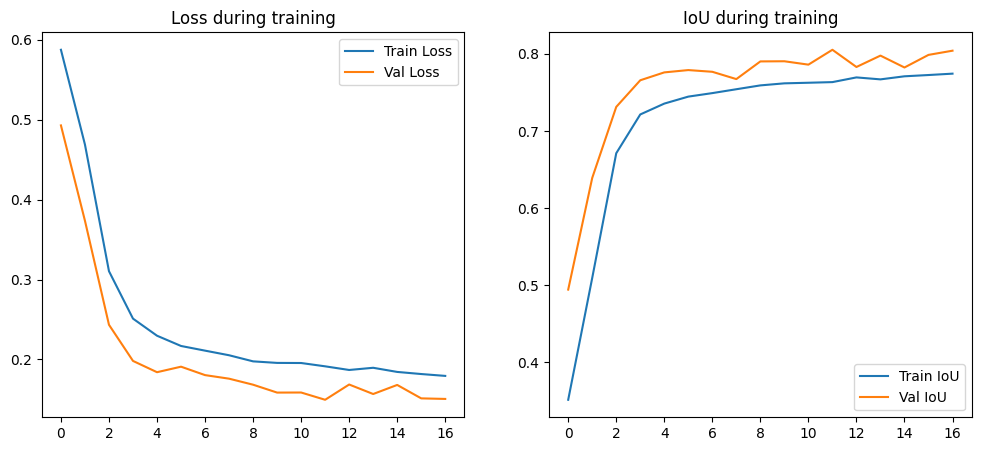

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss during training')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.title('IoU during training')
plt.legend()

plt.show()

In [ ]:
train_dataset = SelfieDataset(train_imgs)
test_dataset = SelfieDataset(test_imgs)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset2, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset2, batch_size=16, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


###  test time аугментации через horizontal flip

In [ ]:
def apply_tta(model, image):
    model.eval()

    # Прямое предсказание
    normal_prediction = model(image.unsqueeze(0))

    # Горизонтальное отражение изображения и предсказание
    flipped_image = torch.flip(image, [2])  # Отражение по ширине
    flipped_prediction = model(flipped_image.unsqueeze(0))
    flipped_prediction = torch.flip(flipped_prediction, [3])  # Возвращаем предсказание к исходной ориентации

    # Усреднение предсказаний
    final_prediction = (normal_prediction + flipped_prediction) / 2
    return final_prediction.squeeze(0)

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализация модели, функции потерь и оптимизатора
model = UNET(3, 16, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


# Для сохранения истории обучения
train_losses, val_losses, train_ious, val_ious = [], [], [], []

num_epochs = 25  # Примерное количество эпох


# early stop
best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 5  # Количество эпох без улучшений после которых обучение будет прервано
early_stop = False


for epoch in range(num_epochs):
    model.train()
    train_loss, train_iou = 0, 0
    for batch in train_loader:
        images, masks = batch['image'].to(device), batch['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)

    scheduler.step()

    train_losses.append(train_loss / len(train_loader))
    train_ious.append(train_iou / len(train_loader))

    # Валидация
    model.eval()
    val_loss, val_iou = 0, 0


    with torch.no_grad():
      for batch in val_loader:
          images, masks = batch['image'].to(device), batch['mask'].to(device)

          # Применение TTA к каждому изображению в батче
          tta_predictions = torch.zeros_like(masks)  # Инициализация тензора для TTA предсказаний
          for i in range(images.size(0)):  # Проходим по изображениям в батче
              tta_prediction = apply_tta(model, images[i])  # Применяем TTA к текущему изображению
              tta_predictions[i] = tta_prediction.unsqueeze(0)  # Добавляем предсказание в тензор предсказаний

          # Расчет потерь и метрик для TTA предсказаний
          loss = criterion(tta_predictions, masks)
          val_loss += loss.item()
          val_iou += jaccard_index((torch.sigmoid(tta_predictions) > 0.5).float(), masks)


    val_losses.append(val_loss / len(val_loader))
    val_ious.append(val_iou / len(val_loader))


    # Проверка на необходимость ранней остановки
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f'\nEarly stopping after {epoch+1} epochs!')
            early_stop = True
            break

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train IoU: {train_ious[-1]}, Val IoU: {val_ious[-1]}')


if not early_stop:
    print("Training completed without early stopping.")
else:
    print("Training completed with early stopping.")
    model.load_state_dict(torch.load('best_model.pth'))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1, Train Loss: 0.3744001526385546, Val Loss: 0.24729206562042236, Train IoU: 0.6394259333610535, Val IoU: 0.7466034889221191
Epoch 2, Train Loss: 0.2513311648741364, Val Loss: 0.2242184564471245, Train IoU: 0.7269710898399353, Val IoU: 0.7600693106651306
Epoch 3, Train Loss: 0.22754401117563247, Val Loss: 0.20631373822689056, Train IoU: 0.7382232546806335, Val IoU: 0.7640408873558044
Epoch 4, Train Loss: 0.21602767128497363, Val Loss: 0.18785428181290625, Train IoU: 0.7501196265220642, Val IoU: 0.7792656421661377
Epoch 5, Train Loss: 0.20631891693919896, Val Loss: 0.18255389481782913, Train IoU: 0.7553154230117798, Val IoU: 0.7858492732048035
Epoch 6, Train Loss: 0.1986812513321638, Val Loss: 0.1671192966401577, Train IoU: 0.7615035772323608, Val IoU: 0.7922337651252747
Epoch 7, Train Loss: 0.19416168984025717, Val Loss: 0.15873271487653257, Train IoU: 0.764328122138977, Val IoU: 0.8037014007568359
Epoch 8, Train Loss: 0.1891812365502119, Val Loss: 0.16244022473692893, Train IoU:

Результат на валидационной выборке чуть лучше, чем предыдущий, но всё ещё сильно хуже, чем первый.

In [ ]:
train_ious = [ious.item() for ious in train_ious]
val_ious = [ious.item() for ious in val_ious]

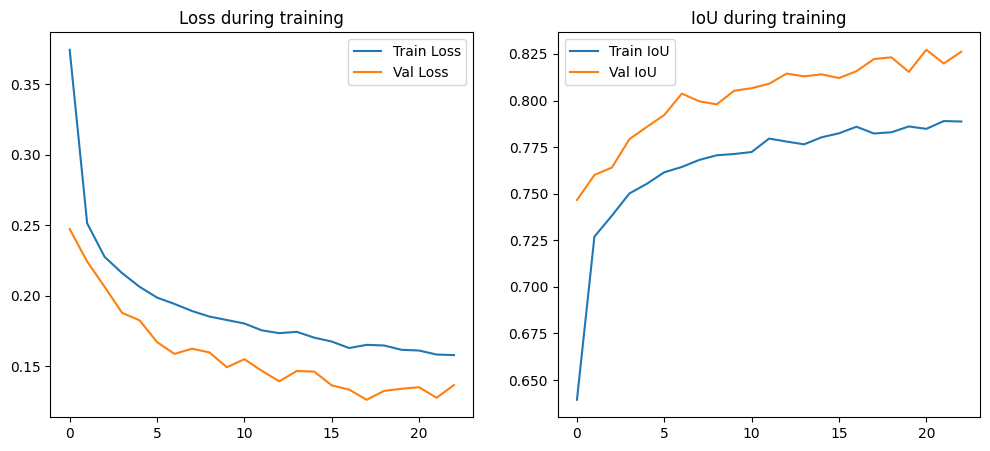

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss during training')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.title('IoU during training')
plt.legend()

plt.show()

## Попробуем изменить модель

### Добавим остаточный блок

In [26]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding=1):  # Добавлен параметр padding с значением по умолчанию
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out



### Добавим модуль внимания

In [27]:
class ChannelAttentionModule(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttentionModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


In [28]:
# Интеграция в CNNBlock
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, padding=1):  # Добавлен параметр padding
        super(CNNBlock, self).__init__()
        self.resblock = ResidualBlock(in_channels, out_channels, padding=padding)  # Передача padding в ResidualBlock
        self.attention = ChannelAttentionModule(out_channels)

    def forward(self, x):
        x = self.resblock(x)
        x = self.attention(x)
        return x


In [29]:
class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x



class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)


In [17]:
from torch.utils.data import DataLoader

train_dataset = SelfieDataset(train_imgs)
val_dataset = SelfieDataset(val_imgs)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [31]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализация модели, функции потерь и оптимизатора
model = UNET(3, 16, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Для сохранения истории обучения
train_losses, val_losses, train_ious, val_ious = [], [], [], []

num_epochs = 25

# Early stop
best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 5  # Количество эпох без улучшений после которых обучение будет прервано
early_stop = False


for epoch in range(num_epochs):
    model.train()
    train_loss, train_iou = 0, 0
    for batch in train_loader:
        images, masks = batch['image'].to(device), batch['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)

    train_losses.append(train_loss / len(train_loader))
    train_ious.append(train_iou / len(train_loader))

    # Валидация
    model.eval()
    val_loss, val_iou = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            images, masks = batch['image'].to(device), batch['mask'].to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_iou += jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)

    val_losses.append(val_loss / len(val_loader))
    val_ious.append(val_iou / len(val_loader))

     # Проверка на необходимость ранней остановки
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f'\nEarly stopping after {epoch+1} epochs!')
            early_stop = True
            break

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train IoU: {train_ious[-1]}, Val IoU: {val_ious[-1]}')


Epoch 1, Train Loss: 0.4268453627824783, Val Loss: 0.3205712139606476, Train IoU: 0.6429855227470398, Val IoU: 0.6613775491714478
Epoch 2, Train Loss: 0.25667481422424315, Val Loss: 0.23495930433273315, Train IoU: 0.7864349484443665, Val IoU: 0.7986745834350586
Epoch 3, Train Loss: 0.19091775566339492, Val Loss: 0.20909907966852187, Train IoU: 0.8188720941543579, Val IoU: 0.7866553664207458
Epoch 4, Train Loss: 0.13855820130556823, Val Loss: 0.1306726947426796, Train IoU: 0.8557023406028748, Val IoU: 0.8642080426216125
Epoch 5, Train Loss: 0.10724684689193964, Val Loss: 0.15068921595811843, Train IoU: 0.884251058101654, Val IoU: 0.8431121110916138
Epoch 6, Train Loss: 0.09001820217818021, Val Loss: 0.11389360874891281, Train IoU: 0.8988276720046997, Val IoU: 0.879429817199707
Epoch 7, Train Loss: 0.08041868768632413, Val Loss: 0.08429874032735825, Train IoU: 0.9075782895088196, Val IoU: 0.9050852656364441
Epoch 8, Train Loss: 0.0631070138886571, Val Loss: 0.07777461484074592, Train IoU

In [32]:
train_ious = [ious.item() for ious in train_ious]
val_ious = [ious.item() for ious in val_ious]

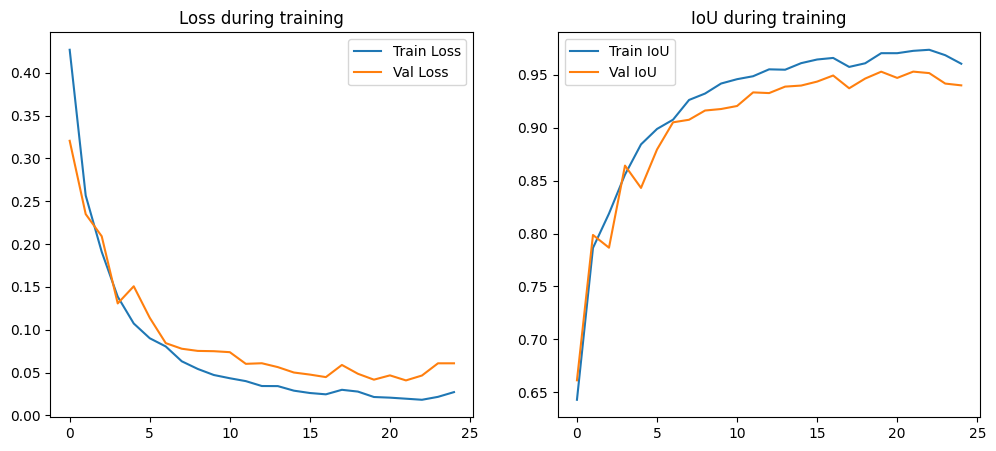

In [33]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss during training')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.title('IoU during training')
plt.legend()

plt.show()

In [34]:
# загрузим лучшую модель
model.load_state_dict(torch.load('best_model.pth'))

# Перевод модели в режим оценки
model.eval()

test_loss, test_iou = 0, 0
test_ious = []  # Список для сохранения IoU каждого тестового батча

# Отключение вычисления градиентов для ускорения и экономии памяти
with torch.no_grad():
    for batch in loader_test:
        images, masks = batch['image'].to(device), batch['mask'].to(device)

        # Получение предсказаний модели
        outputs = model(images)

        # Расчет потерь
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        # Расчет IoU и сохранение результатов
        iou = jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)
        test_ious.append(iou.item())

# Расчет средних значений потерь и IoU по всему тестовому набору
average_test_loss = test_loss / len(loader_test)
average_test_iou = sum(test_ious) / len(test_ious)

print(f'Test Loss: {average_test_loss}, Test IoU: {average_test_iou}')


Test Loss: 0.03978227823972702, Test IoU: 0.9480275924389179


Результат: данная модель показала высокую эффективность. Модуль внимания помогает модели концентрироваться на важных деталях, игнорируя менее значимые области, а остаточные блоки облегчают обучение глубоких сетей, предотвращая исчезновение или взрыв градиентов. Таким образом достигнут самый лучший результат (0.9480275924389179) по метрике IoU из изученных моделей.

## Сделать unet с pretrained энкодером

In [20]:
import torchvision.models as models

# Загрузка предобученной модели ResNet-18
resnet18 = models.resnet18(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 93.5MB/s]


In [21]:
class Decoder(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel):
        super(Decoder, self).__init__()

        self.conv = nn.Conv2d(in_channel, mid_channel, kernel_size=3, stride=1, padding=1) #keep ratio
        self.conv_trans = nn.ConvTranspose2d(mid_channel, out_channel, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.conv(x), inplace=True)
        x = F.relu(self.conv_trans(x), inplace=True)
        return x

class Unet_resnet18(nn.Module):
    def __init__(self, n_classes):
        super(Unet_resnet18, self).__init__()

        #encoder
        self.encoder = resnet18

        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Sequential(self.encoder.conv1, self.encoder.bn1,
                                  self.encoder.relu, self.pool) #64
        self.conv2 = self.encoder.layer1 #64
        self.conv3 = self.encoder.layer2 #128
        self.conv4 = self.encoder.layer3 #256
        self.conv5 = self.encoder.layer4 #depth 512

        #center
        self.center = Decoder(512, 312, 256)

        #decoder
        self.decoder5 = Decoder(256+512, 256, 256)
        self.decoder4 = Decoder(256+256, 128, 128)
        self.decoder3 = Decoder(128+128, 64, 64)
        self.decoder2 = Decoder(64+64, 32, 32)
        self.decoder1 = Decoder(32, 16, 16)
        self.decoder0 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1)

        self.final = nn.Conv2d(8, n_classes, kernel_size=1)

    def forward(self, x):

        #encoder
        conv1 = self.conv1(x) #64x64
        conv2 = self.conv2(conv1) #32x32
        conv3 = self.conv3(conv2) #16x16
        conv4 = self.conv4(conv3) #8x8
        conv5 = self.conv5(conv4) #4x4

        center = self.center(self.pool(conv5)) #4x4
        #decoder
        dec5 = self.decoder5(torch.cat([center, conv5], 1)) #8x8
        dec4 = self.decoder4(torch.cat([dec5, conv4], 1)) #16x16
        dec3 = self.decoder3(torch.cat([dec4, conv3], 1)) #32x32
        dec2 = self.decoder2(torch.cat([dec3, conv2], 1)) #64x64
        dec1 = self.decoder1(dec2) #128x128
        dec0 = F.relu(self.decoder0(dec1))

        final = torch.sigmoid(self.final(dec0))

        return final

In [35]:
class ResNetEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetEncoder, self).__init__()
        # Загрузка предобученной модели ResNet
        self.resnet = models.resnet18(pretrained=pretrained)

        # Удаление полносвязного слоя, так как он не нужен
        self.features = nn.Sequential(*list(self.resnet.children())[:-2])

    def forward(self, x):
        x = self.features(x)
        return x

In [36]:
from torchvision import models
import torch.nn as nn

class ResNetEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetEncoder, self).__init__()
        resnet = models.resnet18(pretrained=pretrained)
        self.initial = nn.Sequential(*list(resnet.children())[:3]) # initial layer
        self.layer1 = nn.Sequential(*list(resnet.children())[3:5]) # layer 1
        self.layer2 = resnet.layer2 # layer 2
        self.layer3 = resnet.layer3 # layer 3
        self.layer4 = resnet.layer4 # layer 4

    def forward(self, x):
        connections = []
        x = self.initial(x)
        connections.append(x)
        x = self.layer1(x)
        connections.append(x)
        x = self.layer2(x)
        connections.append(x)
        x = self.layer3(x)
        connections.append(x)
        x = self.layer4(x)
        connections.append(x)
        return x, connections[::-1] # Возвращает выходы в обратном порядке для декодера


In [37]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        # self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.encoder = ResNetEncoder(pretrained=True)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)




In [25]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализация модели, функции потерь и оптимизатора
model = Unet_resnet18(n_classes=1).to(device) # UNET(3, 16, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Для сохранения истории обучения
train_losses, val_losses, train_ious, val_ious = [], [], [], []

num_epochs = 25


# Early stop
best_val_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 5  # Количество эпох без улучшений после которых обучение будет прервано
early_stop = False


for epoch in range(num_epochs):
    model.train()
    train_loss, train_iou = 0, 0
    for batch in train_loader:
        images, masks = batch['image'].to(device), batch['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou += jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)

    train_losses.append(train_loss / len(train_loader))
    train_ious.append(train_iou / len(train_loader))

    # Валидация
    model.eval()
    val_loss, val_iou = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            images, masks = batch['image'].to(device), batch['mask'].to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_iou += jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)

    val_losses.append(val_loss / len(val_loader))
    val_ious.append(val_iou / len(val_loader))

     # Проверка на необходимость ранней остановки
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == n_epochs_stop:
            print(f'\nEarly stopping after {epoch+1} epochs!')
            early_stop = True
            break

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train IoU: {train_ious[-1]}, Val IoU: {val_ious[-1]}')


Epoch 1, Train Loss: 0.6564369991421699, Val Loss: 0.6207232892513275, Train IoU: 0.5751029849052429, Val IoU: 0.6899450421333313
Epoch 2, Train Loss: 0.6123911201953888, Val Loss: 0.6103771686553955, Train IoU: 0.785950779914856, Val IoU: 0.7903698682785034
Epoch 3, Train Loss: 0.5859354883432388, Val Loss: 0.5591601371765137, Train IoU: 0.8429700136184692, Val IoU: 0.8774677515029907
Epoch 4, Train Loss: 0.5508042350411415, Val Loss: 0.5558136701583862, Train IoU: 0.9181388020515442, Val IoU: 0.9014491438865662
Epoch 5, Train Loss: 0.5498431116342545, Val Loss: 0.5524825990200043, Train IoU: 0.9281989336013794, Val IoU: 0.9202321171760559
Epoch 6, Train Loss: 0.5480958297848701, Val Loss: 0.5497803509235382, Train IoU: 0.9392034411430359, Val IoU: 0.9342155456542969
Epoch 7, Train Loss: 0.5461811065673828, Val Loss: 0.5484512984752655, Train IoU: 0.9522698521614075, Val IoU: 0.9457712173461914
Epoch 8, Train Loss: 0.5452651053667068, Val Loss: 0.5484863340854644, Train IoU: 0.9573550

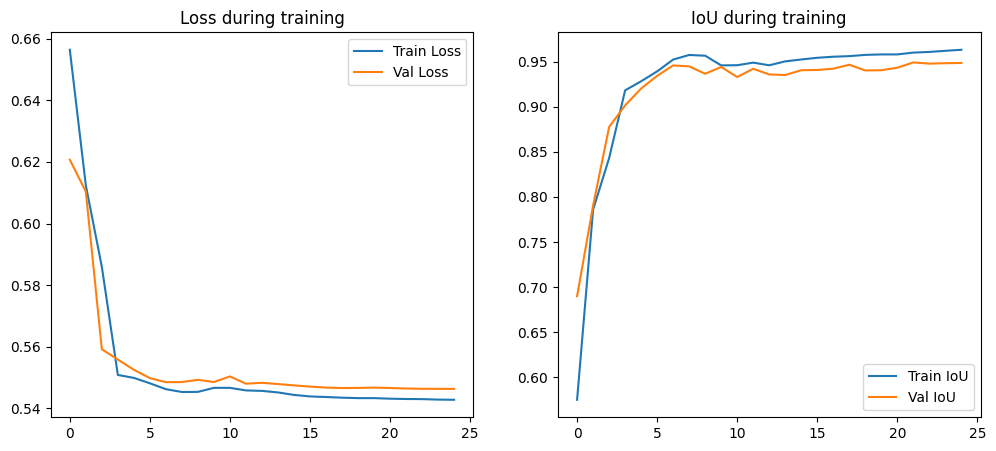

In [26]:
train_ious = [ious.item() for ious in train_ious]
val_ious = [ious.item() for ious in val_ious]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss during training')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.title('IoU during training')
plt.legend()

plt.show()

In [27]:
# загрузим лучшую модель
model.load_state_dict(torch.load('best_model.pth'))

# Перевод модели в режим оценки
model.eval()

test_loss, test_iou = 0, 0
test_ious = []  # Список для сохранения IoU каждого тестового батча

# Отключение вычисления градиентов для ускорения и экономии памяти
with torch.no_grad():
    for batch in loader_test:
        images, masks = batch['image'].to(device), batch['mask'].to(device)

        # Получение предсказаний модели
        outputs = model(images)

        # Расчет потерь
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        # Расчет IoU и сохранение результатов
        iou = jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)
        test_ious.append(iou.item())

# Расчет средних значений потерь и IoU по всему тестовому набору
average_test_loss = test_loss / len(loader_test)
average_test_iou = sum(test_ious) / len(test_ious)

print(f'Test Loss: {average_test_loss}, Test IoU: {average_test_iou}')


Test Loss: 0.5478534285838788, Test IoU: 0.9470520798976605


Результат: данная модель показала высокую эффективность. Результат IoU: 0.9470520798976605 почти равен результату (0.9480275924389179) U-Net с модулем внимания и с остаточныйыми блоками.

## KFold
### Полностью обучить все модели не получилось из-за органичености ресурсов, я решила продолжить с этого пункта на другом colab аккаунте. Но тут можем видетьхорошие результаты на валидационных данных.

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
fold_results = []
models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_imgs)):
    print(f'Fold {fold+1}')
    # Создание наборов данных для текущего фолда
    train_fold_imgs = [train_imgs[i] for i in train_idx]
    val_fold_imgs = [train_imgs[i] for i in val_idx]

    train_fold_dataset = SelfieDataset(train_fold_imgs)
    val_fold_dataset = SelfieDataset(val_fold_imgs)

    train_loader = DataLoader(train_fold_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_fold_dataset, batch_size=32)

    # Создание и обучение модели для текущего фолда


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Инициализация модели, функции потерь и оптимизатора
    model = UNET(3, 16, 1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, train_ious, val_ious = [], [], [], []

    num_epochs = 25


    # Early stop
    best_val_loss = float('inf')
    epochs_no_improve = 0
    n_epochs_stop = 5  # Количество эпох без улучшений после которых обучение будет прервано
    early_stop = False


    for epoch in range(num_epochs):
        model.train()
        train_loss, train_iou = 0, 0
        for batch in train_loader:
            images, masks = batch['image'].to(device), batch['mask'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_iou += jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)

        train_losses.append(train_loss / len(train_loader))
        train_ious.append(train_iou / len(train_loader))

        # Валидация
        model.eval()
        val_loss, val_iou = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                images, masks = batch['image'].to(device), batch['mask'].to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()
                val_iou += jaccard_index((torch.sigmoid(outputs) > 0.5).float(), masks)

        val_losses.append(val_loss / len(val_loader))
        val_ious.append(val_iou / len(val_loader))

        # Проверка на необходимость ранней остановки
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model.pth')
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == n_epochs_stop:
                print(f'\nEarly stopping after {epoch+1} epochs!')
                early_stop = True
                break

        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train IoU: {train_ious[-1]}, Val IoU: {val_ious[-1]}')


    models.append(model)


Fold 1
Epoch 1, Train Loss: 0.4507781667634845, Val Loss: 0.5727236270904541, Train IoU: 0.5960028767585754, Val IoU: 0.3476436734199524
Epoch 2, Train Loss: 0.28213659999892116, Val Loss: 0.2524785250425339, Train IoU: 0.7876127362251282, Val IoU: 0.7762194275856018
Epoch 3, Train Loss: 0.2137323310598731, Val Loss: 0.20334497652947903, Train IoU: 0.8098545074462891, Val IoU: 0.7977918386459351
Epoch 4, Train Loss: 0.16542143002152443, Val Loss: 0.16092409752309322, Train IoU: 0.8431172370910645, Val IoU: 0.8265026807785034
Epoch 5, Train Loss: 0.1353611359372735, Val Loss: 0.13826375640928745, Train IoU: 0.8603284955024719, Val IoU: 0.8443289399147034
Epoch 6, Train Loss: 0.11158798006363213, Val Loss: 0.10970341973006725, Train IoU: 0.8825923204421997, Val IoU: 0.8753957748413086
Epoch 7, Train Loss: 0.091975825605914, Val Loss: 0.10949836485087872, Train IoU: 0.8990076780319214, Val IoU: 0.8850339651107788
Epoch 8, Train Loss: 0.07980049471370876, Val Loss: 0.13831945788115263, Tra